#### 1. 환경 설정

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# 시드 설정 (재현 가능성)
np.random.seed(42)

#### 2. 가상 데이터 생성
- 베어링스 사건 당시 닛케이 225 지수가 고베 대지진(1995년 1월 17일) 이후 급락한 점을 반영해 데이터를 생성

In [ ]:
# 날짜 생성 (1994-12-01 ~ 1995-03-01, 총 91일)
# pd.date_range: 연속된 날짜를 생성. 'D'는 일 단위로, 베어링스 사건 시기를 재현하기 위해 이 범위 선택
dates = pd.date_range(start='1994-12-01', end='1995-03-01', freq='D')

# 닛케이 225 지수 시뮬레이션 (정상 시기 + 급락)
# np.concatenate: 두 배열을 하나로 합침. 실제 닛케이 지수 움직임을 단순화해 시뮬레이션
nikkei = np.concatenate([
    np.random.normal(19000, 200, 46),  # 12월~1월 중순: 평균 19000, 표준편차 200의 정상 분포로 안정적 시기 표현
    np.linspace(19000, 15000, 45) + np.random.normal(0, 100, 45)  # 1월 17일(고베 지진) 이후 선형 하락 + 약간의 노이즈 추가
])

# 닉 리슨의 가상 거래 데이터 (선물 매수 포지션)
# 닉 리슨이 점진적으로 포지션을 늘리다 급격히 확대한 상황 재현
positions = np.concatenate([
    np.linspace(1000, 5000, 46),  # 초기: 선형적으로 1000에서 5000까지 증가 (점진적 매수)
    np.linspace(5000, 20000, 45)  # 이후: 5000에서 20000까지 급격히 증가 (과도한 리스크 노출)
])

# 데이터프레임 생성
# pd.DataFrame: 날짜, 지수, 포지션을 하나의 테이블로 정리. 분석을 쉽게 하기 위해 사용
df = pd.DataFrame({
    'Date': dates,
    'Nikkei225': nikkei,
    'Position': positions
})
df.set_index('Date', inplace=True) # 날짜를 인덱스로 설정해 시간 순서대로 분석 가능

# 손익 계산 (가정: 1포인트 당 5달러 손익)
# diff(): 전일 대비 지수 변화 계산. shift(1): 이전 포지션 기준으로 손익 계산 (실제 거래 반영)
df['Daily_PnL'] = (df['Nikkei225'].diff() * df['Position'].shift(1) * 5).fillna(0) # NaN은 0으로 채움 (첫날 데이터 없음)
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum() # cumsum(): 누적 손익 계산해 총 손실 추적

# 결과 확인
print(df.head(10))
print(df.tail(10))

               Nikkei225     Position     Daily_PnL  Cumulative_PnL
Date                                                               
1994-12-01  19099.342831  1000.000000  0.000000e+00    0.000000e+00
1994-12-02  18972.347140  1088.888889 -6.349785e+05   -6.349785e+05
1994-12-03  19129.537708  1177.777778  8.558153e+05    2.208369e+05
1994-12-04  19304.605971  1266.666667  1.030958e+06    1.251794e+06
1994-12-05  18953.169325  1355.555556 -2.225765e+06   -9.739710e+05
1994-12-06  18953.172609  1444.444444  2.225520e+01   -9.739488e+05
1994-12-07  19315.842563  1533.333333  2.619283e+06    1.645334e+06
1994-12-08  19153.486946  1622.222222 -1.244726e+06    4.006078e+05
1994-12-09  18906.105123  1711.111111 -2.006541e+06   -1.605934e+06
1994-12-10  19108.512009  1800.000000  1.731703e+06    1.257698e+05
               Nikkei225      Position     Daily_PnL  Cumulative_PnL
Date                                                                
1995-02-20  15853.893075  16931.818182 -2.7566

#### 3. 리스크 분석
- 변동성과 포지션 집중도를 계산합니다.

In [ ]:
# 변동성 (20일 롤링 표준편차)
df['Volatility'] = df['Nikkei225'].rolling(window=20).std()

# 포지션 집중도 (최대 포지션 대비 비율)
df['Position_Ratio'] = df['Position'] / df['Position'].max()

#### 4. 이상 탐지 (Isolation Forest)

In [11]:
# 이상 탐지용 데이터 준비
features = df[['Position', 'Daily_PnL', 'Volatility']].dropna()

# Isolation Forest 모델
model = IsolationForest(contamination=0.1, random_state=42)
df.loc[features.index, 'Anomaly'] = model.fit_predict(features)

# 이상치 표시 (음수 값은 이상치)
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})

#### 5. 대안 전략 (헷징)
- 옵션 헷징을 가정해 손실을 줄이는 시뮬레이션

In [ ]:
# 리스크 완화 전략: 헷징 추가 (50% 손익 감소 가정)
# 실제로는 옵션 등으로 헷징 가능. 여기선 단순히 손익의 50%만 반영해 리스크 감소 시뮬레이션

# 헷징 적용 후 손익 (50% 헷징 가정)
df['Hedged_PnL'] = df['Daily_PnL'] * 0.5
df['Cumulative_Hedged_PnL'] = df['Hedged_PnL'].cumsum()

#### 6. 시각화

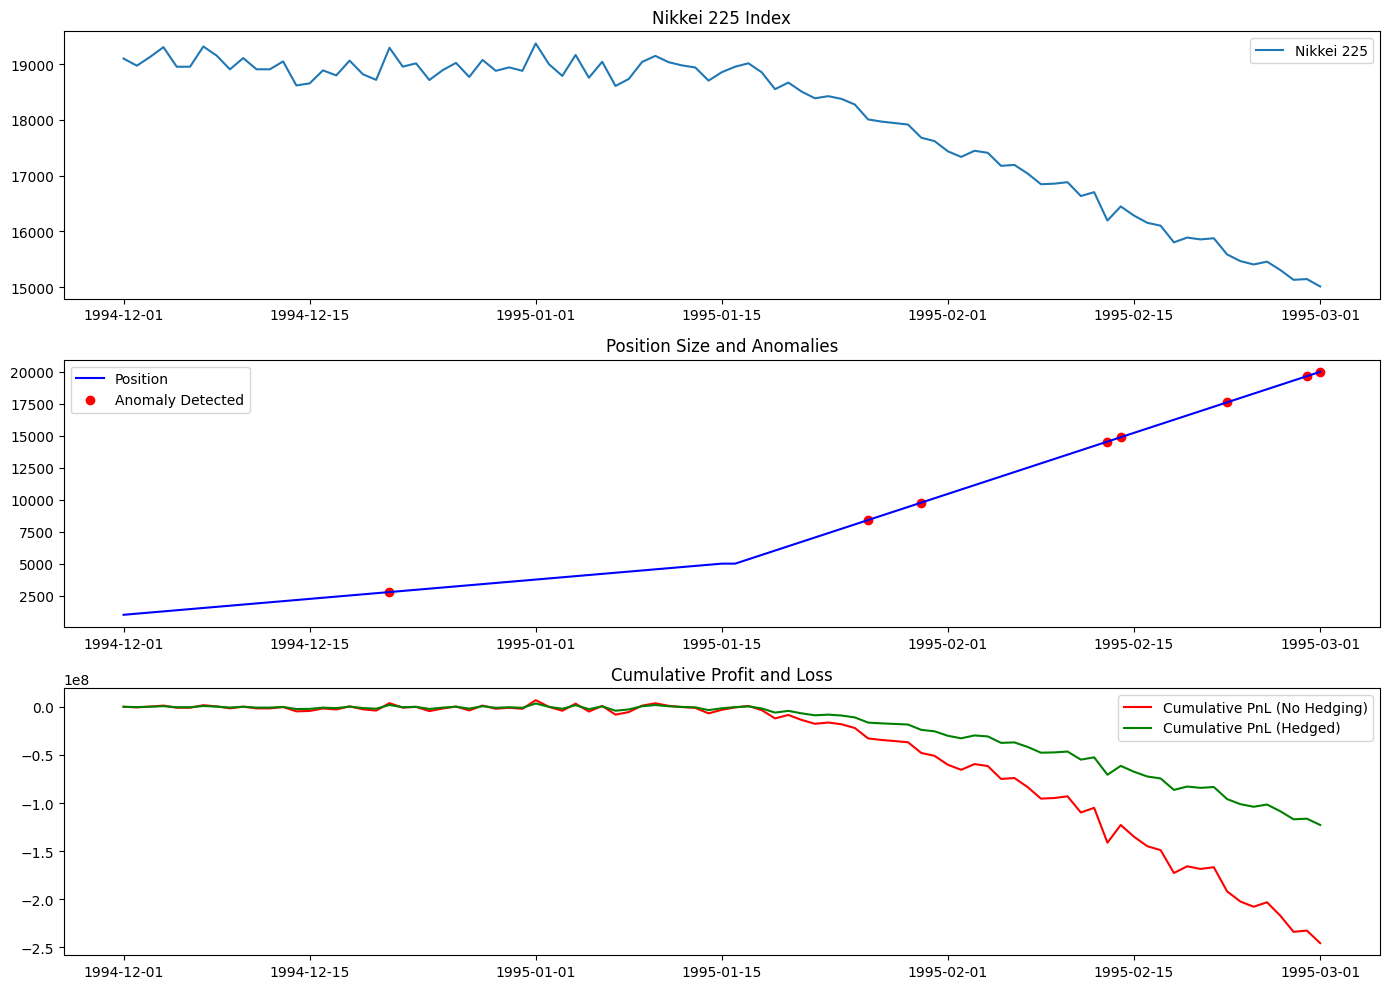

In [13]:
plt.figure(figsize=(14, 10))

# 닛케이 225 지수
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Nikkei225'], label='Nikkei 225')
plt.title('Nikkei 225 Index')
plt.legend()

# 포지션 및 이상 탐지
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Position'], label='Position', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Position'][df['Anomaly'] == 1], 
            color='red', label='Anomaly Detected', marker='o')
plt.title('Position Size and Anomalies')
plt.legend()

# 누적 손익 (헷징 전/후 비교)
plt.subplot(3, 1, 3)
plt.plot(df.index, df['Cumulative_PnL'], label='Cumulative PnL (No Hedging)', color='red')
plt.plot(df.index, df['Cumulative_Hedged_PnL'], label='Cumulative PnL (Hedged)', color='green')
plt.title('Cumulative Profit and Loss')
plt.legend()

plt.tight_layout()
plt.show()

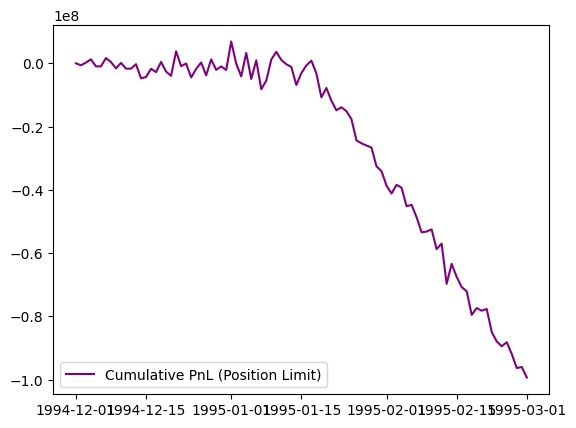

In [14]:
# 포지션 한도 추가 (최대 5000 계약)
df['Limited_Position'] = df['Position'].clip(upper=5000)
df['Limited_PnL'] = (df['Nikkei225'].diff() * df['Limited_Position'].shift(1) * 5).fillna(0)
df['Cumulative_Limited_PnL'] = df['Limited_PnL'].cumsum()

# 그래프에 추가
plt.plot(df.index, df['Cumulative_Limited_PnL'], label='Cumulative PnL (Position Limit)', color='purple')
plt.legend()
plt.show()

In [15]:
import sqlite3

# SQLite 데이터베이스 생성
conn = sqlite3.connect('barings.db')
df.to_sql('trades', conn, if_exists='replace', index=True)

# 이상 거래 쿼리 (포지션이 10000 이상인 경우)
query = "SELECT Date, Nikkei225, Position FROM trades WHERE Position > 10000"
anomalies = pd.read_sql_query(query, conn)
print(anomalies)

conn.close()

                   Date     Nikkei225      Position
0   1995-01-31 00:00:00  17617.797739  10113.636364
1   1995-02-01 00:00:00  17434.821048  10454.545455
2   1995-02-02 00:00:00  17334.924792  10795.454545
3   1995-02-03 00:00:00  17444.888946  11136.363636
4   1995-02-04 00:00:00  17408.351276  11477.272727
5   1995-02-05 00:00:00  17174.617170  11818.181818
6   1995-02-06 00:00:00  17191.262381  12159.090909
7   1995-02-07 00:00:00  17036.163603  12500.000000
8   1995-02-08 00:00:00  16844.578934  12840.909091
9   1995-02-09 00:00:00  16854.321379  13181.818182
10  1995-02-10 00:00:00  16881.076384  13522.727273
11  1995-02-11 00:00:00  16632.781032  13863.636364
12  1995-02-12 00:00:00  16701.918911  14204.545455
13  1995-02-13 00:00:00  16192.570944  14545.454545
14  1995-02-14 00:00:00  16445.826614  14886.363636
15  1995-02-15 00:00:00  16281.431980  15227.272727
16  1995-02-16 00:00:00  16151.917447  15568.181818
17  1995-02-17 00:00:00  16100.085169  15909.090909
18  1995-02-

In [17]:
from time import sleep

# 가상 실시간 데이터 업데이트 (5일씩 추가 시뮬레이션)
for i in range(0, len(df), 5):
    current_df = df.iloc[:i+5]
    anomaly_threshold = current_df['Position'].mean() + 2 * current_df['Position'].std()  # 평균 + 2표준편차로 이상치 탐지
    anomalies = current_df[current_df['Position'] > anomaly_threshold]
    print(f"Detected Anomalies at {current_df.index[-1]}:\n", anomalies[['Position', 'Daily_PnL']])
    sleep(1)  # 1초 대기 (실시간 느낌)

Detected Anomalies at 1994-12-05 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1994-12-10 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1994-12-15 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1994-12-20 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1994-12-25 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1994-12-30 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1995-01-04 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1995-01-09 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1995-01-14 00:00:00:
 Empty DataFrame
Columns: [Position, Daily_PnL]
Index: []
Detected Anomalies at 1995-01-19 00:00:00:
                Position     Daily_PnL
Date     